In [1]:
from utils import load_dataset

import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mutual_info_score, silhouette_score
from sklearn.cluster import KMeans


In [2]:
n_comp = 5
gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)

data = load_dataset('landsat')
gmm.fit(data)

gmm_full = GaussianMixture(n_components=n_comp, covariance_type='tied', max_iter=100)
gmm_full.fit(data)

gmm.score(data), gmm_full.score(data)

kmeans = KMeans(n_clusters=n_comp)

kmeans.fit(data)


/home/skholkin/projects/python_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [3]:
gmm.predict(data)
silhouette_score(data, gmm.predict(data)), silhouette_score(data, gmm_full.predict(data)), silhouette_score(data, kmeans.predict(data))

(0.44595330258613985, 0.4993138231480688, 0.4878128022612768)

In [4]:
gmm.score(data), gmm_full.score(data)

(39.103114576112574, 61.24188211059921)

## Write PSO for k means
## Abstract enougth to run PSO with GMM with sperical components and diagonal ones
## Try to get low variance of inertia/LL

In [3]:
from copy import deepcopy

class Particle:
    def __init__(self):
        self.state = None
        self.pb = None
        self.pb_score = -np.inf
        self.gb = None
    
    def step(self):
        pass
    
    def check_pb(self):
        if self.score() > self.pb_score:
            self.pb = deepcopy(self)
    
    def score(self):
        pass

    def finetune(self):
        pass
    
    def set_gb(self, gb):
        self.gb = deepcopy(gb)
        
    def mutation(self):
        raise NotImplementedError('Mutation is not implemented')
    
class PSO:
    def __init__(self, particles, n_steps):
        self.particles = particles
        self.n_steps = n_steps
        self.gb_particle, self.gb_score = None, -np.inf
        self.check_gb()
        
    def check_gb(self):
        for particle in self.particles:
            score = particle.score()
            if score > self.gb_score:
                self.gb_score = score
                self.gb_particle = deepcopy(particle)
                
        gb = deepcopy(self.gb_particle)
        for particle in self.particles:
            particle.set_gb(gb)
            
    def check_for_mutation(self):
        self.gb_score
        for i, particle in enumerate(self.particles):
            p_score = particle.score()
            if np.absolute(p_score - self.gb_score) < 5e-2:
                particle.mutation()
        
    def run(self):
        print(f'Init: gb ll {self.gb_score}')
        for step in range(self.n_steps):
            for i, particle in enumerate(self.particles):
                particle.step()
                particle.finetune()
                particle.check_pb()
#                 print(f'{i} score {particle.score()}')
#             print(f'Step {step} {[item.score() for item in self.particles]}')
            self.check_gb()
            print(f'Step {step}: gb ll {self.gb_score}')
            self.check_for_mutation()
        return self.gb_score
        
            

### For GMM with spherical components

In [6]:

    
class GMMSpherical(Particle):
    def __init__(self, data, n_comp, init_state, intertia, r_1, r_2):
        super(Particle, self).__init__()
        self.state = init_state
        self.intertia, self.r_1, self.r_2 = intertia, r_1, r_2
        self.velocity = {key: np.zeros_like(value) for key, value in init_state.items()}
        self.pb, self.pb_score = deepcopy(self), -np.inf
        self.gb = None
        self.data = data
        self.n_comp = n_comp
        
    def step(self):
        c_1, c_2 = np.random.uniform(), np.random.uniform()
        for key in self.velocity.keys():
            self.velocity[key] = self.intertia * self.velocity[key] + self.r_1 * c_1 * (self.pb.state[key] - self.state[key]) + self.r_2 * c_2 * (self.gb.state[key] - self.state[key])
#             self.velocity[key] += 0.001 * np.random.normal(size=self.velocity[key].shape)
            self.state[key] += self.velocity[key]
        self.state['var'] = np.absolute(self.state['var'])
        self.state['weights'] = np.absolute(self.state['weights'])
        self.state['weights'] = self.state['weights'] / np.sum(self.state['weights'])
        
    def score(self):
        # create sklearn.mixture.Gmm from self.state
        means = self.state['means']
        var = self.state['var']
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=0)
        
        cholesky = 1 / np.sqrt(var)
        gmm.weights_ = weights
        gmm.means_ = means
        gmm.precisions_cholesky_ = cholesky
        
        return gmm.score(self.data)
    
    def finetune(self):
        
        means = self.state['means']
        var = self.state['var']
        prec = 1 / var
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=self.n_comp, covariance_type='spherical', weights_init=weights, means_init=means, precisions_init=prec, max_iter=100,  verbose=0, verbose_interval=1)
        gmm.fit(self.data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        
        self.state['means'] = means
        self.state['var'] = var
        self.state['weights'] = weights
        

gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)
gmm.fit(data)

init_state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}

particle = GMMSpherical(data, n_comp, init_state, 0.4, 0.4, 0.6)
particle.set_gb(particle)
print(particle.score())
print(particle.step())
print(particle.score())
particle.finetune()
particle.score()

38.877564584553205
None
38.877564584553205


38.87902642963338

In [7]:
pso = None
import gc
gc.collect()

0

In [8]:
def create_spherical_particles(n_particles, n_comp, data):
    particles = []
    for i in range(n_particles):
        gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)
        gmm.fit(data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}
        particles.append(state)
        
    return [GMMSpherical(data, n_comp, state, 0.4, 0.4, 0.6) for state in particles]

particles = create_spherical_particles(50, 10, data)


In [9]:
pso = PSO(particles, 5)
pso.run()

Init: gb ll 47.488585306784685
Step 0: gb ll 47.50107914869202


NotImplementedError: Mutation is not implemented

In [ ]:

gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100, n_init=300)
gmm.fit(data)
gmm.score(data)

In [ ]:

data = load_dataset('Synthetic_dim_50_n_samples_1000_n_comp_15_c_separation_1.0.data.npy')

In [ ]:
data.shape

### For GMM with diagonal covariance matrices

In [4]:

    
class GMMDiagonal(Particle):
    def __init__(self, data, n_comp, init_state, intertia, r_1, r_2):
        super(Particle, self).__init__()
        self.state = init_state
        self.intertia, self.r_1, self.r_2 = intertia, r_1, r_2
        self.velocity = {key: np.zeros_like(value) for key, value in init_state.items()}
        self.gb = None
        self.data = data
        self.n_comp = n_comp
        self.pb, self.pb_score = None, -np.inf
        self.history = []
        
    def step(self):
        if self.pb is None:
            self.pb = self.copy()
        c_1, c_2 = np.random.uniform(), np.random.uniform()
        for key in self.velocity.keys():
            self.velocity[key] = self.intertia * self.velocity[key] + self.r_1 * c_1 * (self.pb.state[key] - self.state[key]) + self.r_2 * c_2 * (self.gb.state[key] - self.state[key])
#             self.velocity[key] += 0.001 * np.random.normal(size=self.velocity[key].shape)
            self.state[key] += self.velocity[key]
        self.state['var'] = np.absolute(self.state['var'])
        self.state['weights'] = np.absolute(self.state['weights'])
        self.state['weights'] = self.state['weights'] / np.sum(self.state['weights'])
        
    def mutation(self):
        self.state['means'] += 0.01 * np.random.normal(size=self.state['means'].shape)
#         print(np.mean(self.state['means']))
        self.state['var'] += 0.1 * np.random.uniform() * self.state['var']
        
    def score(self):
        # create sklearn.mixture.Gmm from self.state
        
        means = self.state['means']
        var = self.state['var']
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=0)
        
        cholesky = 1 / np.sqrt(var)
        gmm.weights_ = weights
        gmm.means_ = means
        gmm.precisions_cholesky_ = cholesky
        
        return gmm.score(self.data)
    
    def finetune(self):
        
        means = self.state['means']
        var = self.state['var']
        prec = 1 / var
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=self.n_comp, covariance_type='diag', weights_init=weights, means_init=means, precisions_init=prec, max_iter=100,  verbose=0, verbose_interval=1)
        gmm.fit(self.data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        
        self.state['means'] = means
        self.state['var'] = var
        self.state['weights'] = weights
        
        self.history.append(self.score())

    def copy(self):
        state_copy = deepcopy(self.state)
        return GMMDiagonal(self.data, self.n_comp, state_copy, self.intertia, self.r_1, self.r_2)
        


In [5]:

gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100)
gmm.fit(data)

init_state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}

particle = GMMDiagonal(data, n_comp, init_state, 0.4, 0.4, 0.6)
particle.set_gb(particle)
print(particle.score())
print(particle.step())
print(particle.score())
particle.finetune()
print(particle.score())
particle.mutation()
print(particle.score())
particle.history

40.88813611419647
None
40.88813611419647
40.888630951977426
40.37796421897593


[40.888630951977426]

In [6]:
def create_diag_particles(n_particles, n_comp, data):
    particles = []
    for i in range(n_particles):
        gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100)
        gmm.fit(data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}
        particles.append(state)
        
    return [GMMDiagonal(data, n_comp, state, 0.4, 0.4, 0.6) for state in particles]


In [7]:

particles = create_diag_particles(50, n_comp, data)
pso = PSO(particles, 5)
pso.run()


Init: gb ll 41.47070896288857
Step 0: gb ll 41.814792075277225
Step 1: gb ll 41.81895547374565
Step 2: gb ll 41.82032683137328
Step 3: gb ll 41.82060352564824
Step 4: gb ll 41.82063022142134


41.82063022142134

(41.0, 42.0)

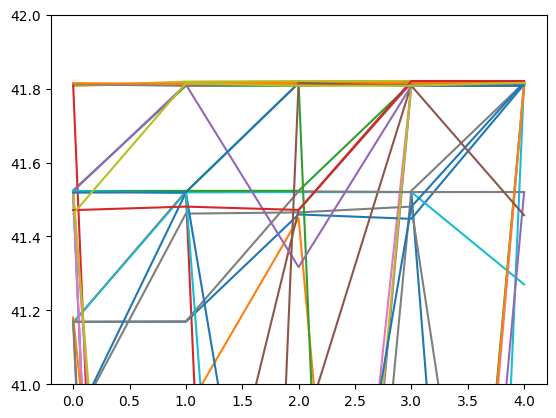

In [12]:
all_history = [item.history for item in pso.particles]
import matplotlib.pyplot as plt 
for history in all_history:
    plt.plot(np.arange(len(history)), history)

plt.ylim([41, 42])

In [13]:

gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100, n_init=100)
gmm.fit(data)
gmm.score(data)

41.47082850452167